### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [4224]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, recall_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
import warnings

In [4378]:
class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('name error')
            raise
    
    def __gini(self, p):
        return 1 - (p**2).sum(axis=1)

    def __entropy(self, p):
        return - np.sum(p*np.log2(p+0.0000001), axis=1)

    def __misclass(self, p):
        return 1 - p.max(axis=1)

    
    def __get_feature_ids(self, n_feature):
        return range(n_feature)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]
    
    def __find_threshold(self, x, y):
        x_sort, y_sort=self.__sort_samples(x,y)
        
        cut = np.int(self.min_samples_split / 2 - 1)
        y_sort_slit = y_sort[cut:-cut] if cut != 0 else y_sort
        indexes = np.where(y_sort_slit[:-1] != y_sort_slit[1:])[0] + (cut + 1)
        
        #Отсутствие смещения класса
        if len(indexes) == 0:
            return np.inf, None
        
        eq_count = indexes - np.append([cut], indexes[:-1])
        one_hot_code = np.zeros((indexes.shape[0], self.num_class))
        one_hot_code[np.arange(indexes.shape[0]), y_sort[indexes - 1]] = 1
        
        class_increments = one_hot_code * eq_count.reshape(-1, 1)
        class_increments[0] = class_increments[0] + np.bincount(y_sort[:cut], minlength=self.num_class)
        
        
        # количество классов слева и справа в разбиении 
        l_class_count = np.cumsum(class_increments, axis=0)
        r_class_count = np.bincount(y_sort, minlength=self.num_class) - l_class_count
    
        # количество объектов слева и справа в разбиении
        l_sizes = indexes.reshape(l_class_count.shape[0], 1)
        r_sizes = y_sort.shape[0] - l_sizes
        
        gs_l = self.G_function(l_class_count/l_sizes)*(l_sizes/(l_sizes+r_sizes)).T
        gs_r = self.G_function(r_class_count/r_sizes)*(r_sizes/(l_sizes+r_sizes)).T
        gs = gs_l.T + gs_r.T

        indx = np.argmin(gs)
        
        st_ind = l_sizes[indx][0]
        
        return gs[indx], (x_sort[st_ind - 1] + x_sort[st_ind]) / 2.0
    
    
    def __fit_node(self, x, y, node_id, depth):
        #создаем терминал.
        if (self.max_depth<=depth) or y.size < self.min_samples_split:
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / y.size)
            return
                
        # разбиваем
        threshold = np.array([self.__find_threshold(x[:, i], y) for i in self.__get_feature_ids(x.shape[1])])
        
        # оптимальная группаа
        best_id = threshold[:, 0].argmin()
        best_threshold = threshold[best_id, 1]
        
        #если узел создался и нашлась группа, то спускаемся по дереву дальше, если нет, то создаем терминал.
        if best_threshold == None:
            self.tree[node_id] = (self.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / y.size)
        else:
            x_l, x_r, y_l, y_r =self.__div_samples(x, y, best_id, best_threshold)
            if x_l.size == 0 or x_r.size == 0:
                self.tree[node_id] = (self.LEAF_TYPE,np.bincount(y).argmax(),np.bincount(y).astype(float) / y.size)
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE,best_id, best_threshold)
                self.__fit_node(x_l, y_l,2 * node_id + 1, depth + 1)
                self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)
            # Для последнего этапа. Очевидно, лучше считать здесь. Просто считаем gain лучших фичей и плюсуем 
            # в feature_importances_ по индексу
            if self.G_function == self.__gini:
                g=(1 - np.sum(np.unique(y, return_counts=True)[1]** 2 / y.size ** 2))
                g_l=(1 - np.sum(np.unique(y_l, return_counts=True)[1] ** 2 / y_l.size ** 2))
                g_r=(1 - np.sum(np.unique(y_r, return_counts=True)[1] ** 2 / y_r.size ** 2))
                self.feature_importances_[best_id] += (y.size*g - y_l.size*g_l - y_r.size*g_r)/y.size
            if self.G_function == self.__entropy:
                g=-(np.sum((np.unique(y, return_counts=True)[1] / y.size) * np.log2(np.unique(y, return_counts=True)[1] / y.size)))
                g_l=-(np.sum((np.unique(y_l, return_counts=True)[1] / y_l.size) * np.log2(np.unique(y_l, return_counts=True)[1] / y_l.size)))
                g_r=-(np.sum((np.unique(y_r, return_counts=True)[1] / y_r.size) * np.log2(np.unique(y_r, return_counts=True)[1] / y_r.size)))
                self.feature_importances_[best_id] += (y.size*g - y_l.size*g_l - y_r.size*g_r)/y.size   
            elif self.G_function == self.__misclass:
                g=(1 - np.max(np.sum(np.unique(y, return_counts=True)[1] / y.size)))
                g_l=(1 - np.max(np.sum(np.unique(y_l, return_counts=True)[1] / y.size)))
                g_r=(1 - np.max(np.sum(np.unique(y_r, return_counts=True)[1] / y.size)))
                self.feature_importances_[best_id] += (y.size*g - y_l.size*g_l - y_r.size*g_r)/y.size
            
    
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.feature_importances_ = np.zeros(x.shape[1], dtype=np.float)
        self.total = y.size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        # индексы десяти главных фичей
        return (self.feature_importances_)

In [4232]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

print("Not my")
print(f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro'))
print("My")
print(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

Not my
0.8885003885003885
My
0.9487179487179486


In [4233]:
print(my_clf.tree)

{0: (0, 12, 755.0), 1: (0, 6, 2.165), 3: (0, 3, 27.5), 7: (1, 1, array([0., 1.])), 8: (1, 0, array([1.])), 4: (0, 1, 2.085), 9: (1, 2, array([0., 0., 1.])), 10: (1, 1, array([0., 1.])), 2: (0, 6, 1.28), 5: (0, 9, 7.3), 11: (1, 2, array([0., 0., 1.])), 12: (0, 0, 13.175), 25: (0, 0, 13.29), 51: (1, 1, array([0., 1.])), 52: (1, 0, array([1.])), 26: (1, 1, array([0., 1.])), 6: (0, 9, 3.725), 13: (1, 2, array([0., 0., 1.])), 14: (1, 1, array([0., 1.]))}


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [4247]:
%time clf.fit(X_train, y_train)

Wall time: 1.97 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [4325]:
%time my_clf.fit(X_train, y_train)

Wall time: 11.9 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [4393]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

#Удалим очевидно лишние колонки
df = df.iloc[:, :97]
df = df.drop(['id', 'idg', 'condtn', 'round', 'position',
              'positin1', 'order', 'partner', 'age_o', 'race_o',
              'pf_o_att', 'pf_o_sin', 'pf_o_int', 'pf_o_fun',
              'pf_o_amb', 'pf_o_sha', 'dec_o', 'attr_o',
              'sinc_o', 'intel_o', 'fun_o', 'amb_o',
              'shar_o', 'like_o', 'prob_o', 'met_o', 'field',
              'undergra', 'from', 'zipcode', 'career',
              'sports', 'tvsports', 'exercise', 'dining',
              'museums', 'art', 'hiking', 'gaming',
              'clubbing', 'reading', 'tv', 'theater',
              'movies', 'concerts', 'music', 'shopping', 'yoga',
              'expnum', ], axis=1)

#Займёмся коррекцией колонок, удалим NaN, бесконечности и т. п.
df = df.dropna(subset=['age'])
df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)
df.loc[:, 'mn_sat'] = df.loc[:, 'mn_sat'].str.replace(',', '').astype(np.float)
df.loc[:, 'mn_sat'] = df.mn_sat.fillna(-999)
df.loc[:, 'tuition'] = df.loc[:, 'tuition'].str.replace(',', '').astype(np.float)
df.loc[:, 'tuition'] = df.tuition.fillna(-999)
df = df.dropna(subset=['imprelig', 'imprace'])
df.loc[:, 'income'] = df.loc[:, 'income'].str.replace(',', '').astype(np.float)
df.loc[:, 'income'] = df.loc[:, 'income'].fillna(-999)
df = df.dropna(subset=['date'])
df.loc[:, 'career_c'] = df.loc[:, 'career_c'].fillna(18)


feat = ['iid', 'wave', 'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']
temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] =\
    (df.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100


feat = ['iid', 'wave', 'attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']

temp = df.drop_duplicates(subset=['iid', 'wave']).loc[:, feat]
temp.loc[:, 'totalsum'] = temp.iloc[:, 2:].sum(axis=1)
df.loc[:, 'temp_totalsum'] = df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] =\
    (df.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].T / df.loc[:, 'temp_totalsum'].T).T * 100

df = df.drop(['temp_totalsum'], axis=1)


for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]
    if i != 4:
        feat.remove('shar{}_1'.format(i))
    df = df.drop(feat, axis=1)
    
df = df.drop(['wave'], axis=1)

df_male = df.query('gender == 1').drop_duplicates(subset=['iid', 'pid']).drop(['gender'], axis=1).dropna()
df_female = df.query('gender == 0').drop_duplicates(subset=['iid']).drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
                                   .dropna()
df_female.columns = df_female.columns + '_f'
df_female = df_female.drop(['pid_f'], axis=1)
df_pair = df_male.join(df_female.set_index('iid_f'), on='pid', how='inner')
df_pair = df_pair.drop(['iid', 'pid'], axis=1)

feature_names = df_pair.columns[1:]

In [4396]:
X = df_pair.iloc[:, 1:].values
y = df_pair.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

my_clf = MyDecisionTreeClassifier()
clf = DecisionTreeClassifier(min_samples_split=2,max_depth=5,criterion='gini') #чтобы установить равные условия(я про аргументы)

clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

print("Not my")
print(f1_score(y_pred=clf.predict(X_test), y_true=y_test, average='macro'))
print("My")
print(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

Not my
0.5017679202828672
My
0.5520351855999673


# Кросс-валидация

In [4334]:
samples=range(1, 71)
crits=['gini','entropy','misclass']
depths=range(1, 21)

In [4397]:
#Если precission и recall равны 0, то f1 не сможет посчитаться по формуле, а значит будет установлен нулевой score
#Это нормально, так как нулевые precission и recall нам не подходят
#Поэтому просто игнорируем замечания f1-score, чтобы не нервничать
warnings.filterwarnings('ignore') 

m_c=[]
for crit in tqdm(crits):
    my_clf = MyDecisionTreeClassifier(criterion=crit)
    my_clf.fit(X_train, y_train)
    valid=cross_val_score(my_clf, X_train, y_train, cv=8, scoring="f1").mean()
    m_c.append(valid)

In [4398]:
max_crit_f1=crits[np.argmax(m_c)]
max_crit_f1

'gini'

In [4337]:
warnings.filterwarnings('ignore') 

max_score=0
for sample in tqdm(samples):
    for depth in (depths):
        my_clf = MyDecisionTreeClassifier(min_samples_split=sample, max_depth=depth, criterion=max_crit_f1)
        my_clf.fit(X_train, y_train)
        valid=cross_val_score(my_clf, X_train, y_train, cv=8, scoring="f1").mean()
        if valid>max_score:
            max_score=valid
            max_samp_f1=sample
            max_depth_f1=depth

In [4413]:
print(max_samp_f1, max_depth_f1, max_crit_f1)

4 11 gini


In [4419]:
my_clf = MyDecisionTreeClassifier(min_samples_split=max_samp_f1, max_depth=max_depth_f1, criterion=max_crit_f1)
my_clf.fit(X_train, y_train)
print(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.5716216927965729
0.8475


# Графики

In [4420]:
warnings.filterwarnings('ignore') 
m1=[]
m2=[]
for samp in tqdm(samples):
    my_clf = MyDecisionTreeClassifier(min_samples_split=samp, max_depth=max_depth_f1, criterion=max_crit_f1)
    my_clf.fit(X_train, y_train)
    m1.append(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

for depth in tqdm(depths):
    my_clf = MyDecisionTreeClassifier(max_depth=depth, criterion=max_crit_f1)
    my_clf.fit(X_train, y_train)
    m2.append(f1_score(y_pred=my_clf.predict(X_test), y_true=y_test, average='macro'))

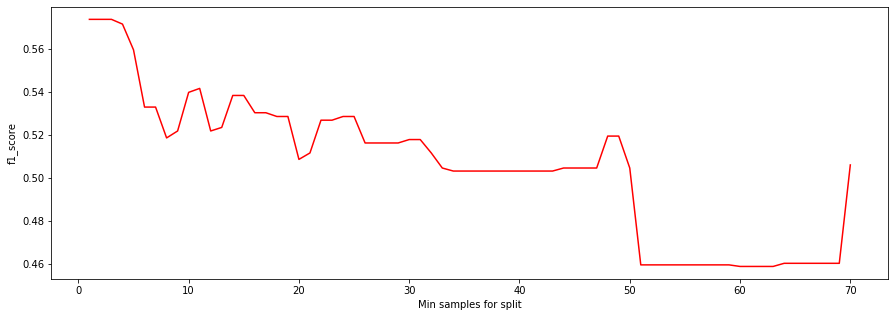

In [4421]:
%matplotlib inline

plt.figure(figsize=(15, 5))
plt.plot(samples,m1,'r')
plt.ylabel('f1_score')
plt.xlabel('Min samples for split')

fig.tight_layout()

Интересно, что у Джини максимумы вначале, что нельзя сказать про ту же энтропию. Почему? Не знаю. Но интересное наблюдение.

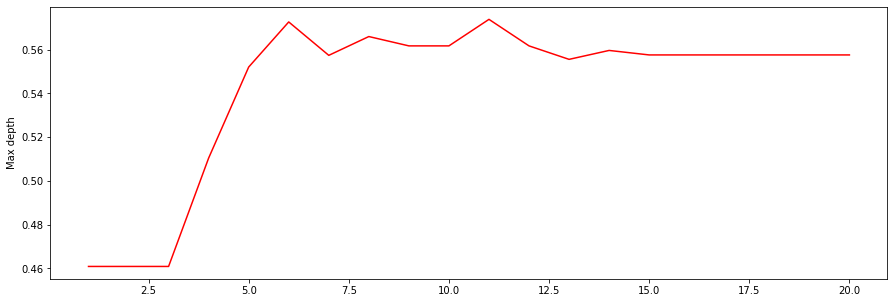

In [4422]:
%matplotlib inline

plt.figure(figsize=(15, 5))
plt.plot(depths,m2,'r')
plt.ylabel('f1_score')
plt.ylabel('Max depth')

fig.tight_layout()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [4423]:
my_clf = MyDecisionTreeClassifier(min_samples_split=max_samp_f1, max_depth=max_depth_f1, criterion=max_crit_f1)
my_clf.fit(X_train, y_train)
Most_important=feature_names[np.argsort(my_clf.get_feature_importance())[-10:]]

print(list(Most_important))
#По важности (с конца)

['income', 'shar2_1', 'income_f', 'field_cd', 'sinc2_1_f', 'age', 'attr3_1_f', 'age_f', 'race_f', 'int_corr']


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Как вы могли заметить, я не считал поноценный функционал для сплита (не прибавлял гейн для основного узла), считал только долевые гейны для левого и правого узла, а потом минимизировал их (полный функционал пришлось бы максимизировать). Я не понимаю, почему, но при подсчёте и максимизации полного функционала моё дерево не работает. А вот тот вариант, который я реализовал, работает очень даже неплохо. Но это странно, ведь на лекции нам говорили про максимизацию полного функционала.

Тут уже вопрос не к деревьям, а к кросс-валидации. Правильно ли я её реализовал? В целом, вопросов больше нет по ней.

Очень сложно! Хорошо, что это кончилось. Надеюсь, я не облажался. Проблем было много. В целом, самая главная проблема в том, что кросс-валидация долго отказывалась выдавать НОРМАЛЬНЫЕ параметры. Пришлось даже 8 фолдов поставить, чтобы размер валидационной выборке был равен тесту. Ждал миллион лет. Ну и самым (казалось бы) тяжёлым оказалась обработка данных. Хорошо, что вы оставили ссылку на гит. Без неё я бы точно не справился. Много непонятного осталось связанного с обработкой, поэтому надеюсь, что моя обработка годится. 
Спасибо за проверку!